<a href="https://colab.research.google.com/github/argennof/Data_A-V_2022/blob/main/Dany_Entregable_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DIPLOMATURA 2022**

# ANALISIS Y VISUALIZACION DE DATOS

## GRUPO Nº24

## INTEGRANTES:
   - [x] Daniel Rubio
   - [x] Clarisa Manzone
   - [x] Diana Fonnegra
   - [x] Nico Rosales


## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

### Bibliotecas estándar. Lectura del conjunto de datos.

In [124]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn

seaborn.set_context('talk')

url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df_raw_data = pd.read_csv(url)


### Previo al cálculo de las estimaciones solicitadas proponemos mantener los criterios aplicados al entregable parte 1 para el acondicionamiento y filtrado de datos:


In [125]:
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'salary_monthly_BRUTO', 'profile_gender']

# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df_raw_data.loc[:, 'cured_programming_languages'] = df_raw_data.tools_programming_languages\
    .apply(split_languages)

if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# print('---------- ---------- ---------- ----------\n')
# print(f"Observando las características de la variable cured_programming_languages:\n{df_raw_data.cured_programming_languages}")
# print('---------- ---------- ---------- ----------\n')

# Realizamos un Subset del conjunto inicial solo con las columnas de interés

df_relevant = df_raw_data[relevant_columns]


### Restricción del espacio muestral (Idem parte 1):
## Nueva sección
Se crean filtros a fin de descartar registros que no son de interes o que presentan inconsistencias:
   - [x] Extraer aquellos registros en los que el encuestado marco que no programaba ningún lenguaje o el campo correspondiente aparece vacio en lenguaje: ```(tools_programming_languages <> ninguno)```,inconsistentes dado el objetivo del análisis. ->(Condición 0, 1 y 2)
   - [x] Excluir aquellos salarios que sean iguales o inferiores a un determinado monto dado que los mismos podrian ser considerados como _"Outlayers"_, en nuestro caso este se fijo en: $15000 Ars. ->(Condición 3)
   - [x] Excluimos donde la proporción de descuento entre el Bruto y el Neto es inconsistente. ->(Condición 4)


#### Expresando los filtros con ayuda de Python:



In [126]:
cut_off_salary = 15000

# Filtros de ingreso Cadana vacia o nula
filter_0 = df_relevant ["cured_programming_languages"].apply(lambda x: [] == x) 
filter_1 = df_relevant ["cured_programming_languages"].apply(lambda x: '' in x) 

# Filtros de ingreso Ninguno 
filter_2 = df_relevant ["cured_programming_languages"].apply(lambda x: 'ninguno' in [i.lower() for i in x]) 

# Filtro donde el salario NETO no es de interés:
filter_3 = df_relevant ["salary_monthly_NETO"] > cut_off_salary

# Filtro donde el salario NETO supera al BRUTO - inconsitente:
filter_4 = df_relevant ["salary_monthly_NETO"] >  df_relevant ["salary_monthly_BRUTO"]

# Otros filtos a colocar
filter = (~filter_0) & (~filter_1) & (~filter_2) & (filter_3) & (~filter_4) 

### Creando el set de datos filtrado:

In [127]:
# Set de datos filtrados:
df_filtered = df_relevant[filter]

### Antes de continuar con el proceso de estimación debemos verificar la consistencia en los datos de genero presentes en nuestra muestras:


In [128]:
df_filtered["profile_gender"].unique()

array(['Hombre', 'Otros', 'Mujer'], dtype=object)

Los generos presentes en los regitros muestrales a estudiar son:
   - [x] Hombre
   - [x] Mujer
   - [x] Otros
   
Por le expuesto los registro de género se consideran consistentes sin la necesidad de aplicar tratamiento extra de curación.

### Realizaremos un relevamiento prelimiar a fin de obtener una descripción del grupo de datos bajo estudio:

 
### Medidas de posición y dispersión:

In [129]:
df_filtered[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                         \
                             count           mean            std      min   
profile_gender                                                              
Hombre                      4002.0  104737.269593  102697.036594  15600.0   
Mujer                        601.0   77700.812729   52017.585453  16000.0   
Otros                         26.0  107250.000000   89911.615490  34000.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          58000.0  83000.0  112000.0  2080000.0  
Mujer           47000.0  67000.0   93000.0   750000.0  
Otros           41250.0  78900.0  127000.0   380000.0

### Histrogramas de frecuencias según género:

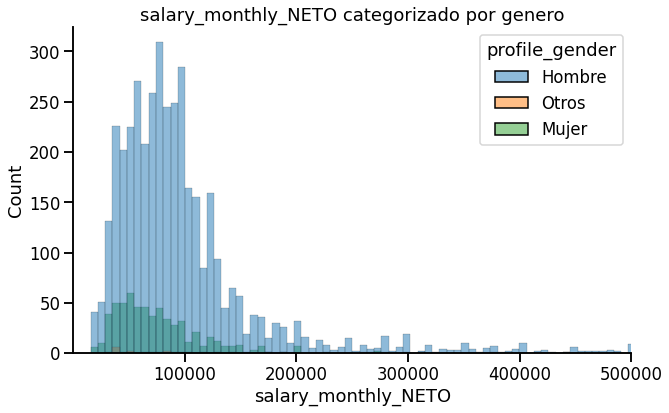

In [130]:
fig, ax = plt.subplots(figsize=(10,6))
seaborn.color_palette("Set2")
seaborn.despine()
seaborn.histplot(df_filtered, x="salary_monthly_NETO", ax = ax, hue="profile_gender", fill=True)
ax.set_xlim(1, 500000) # Se restringe la visualización al máximo de $500000.
plt.title("salary_monthly_NETO categorizado por genero");


### Conformación de los grupos separados por género:


   - GrupoA = salario Neto del grupo de Hombres
   - GrupoB = salario Neto para otros género

In [131]:
# Definicion de filtro para género = "Hombre"
is_man = df_filtered.profile_gender == 'Hombre'

# Definición de grupo A y B
groupA = df_filtered[is_man]
groupB = df_filtered[~is_man]

# Conteo de puntos muestrales que componen cada grupo
nA = len(groupA)
nB = len(groupB)
print(f'El grupo de encuestados cuyo genero:')
print(f'  - Es "Hombre"se compone de {nA} muestras.')
print(f'  - NO es "Hombre"se compone de {nB} muestras.')

El grupo de encuestados cuyo genero:
  - Es "Hombre"se compone de 4002 muestras.
  - NO es "Hombre"se compone de 627 muestras.


### Histrogramas de frecuencias GrupoA - GrupoB

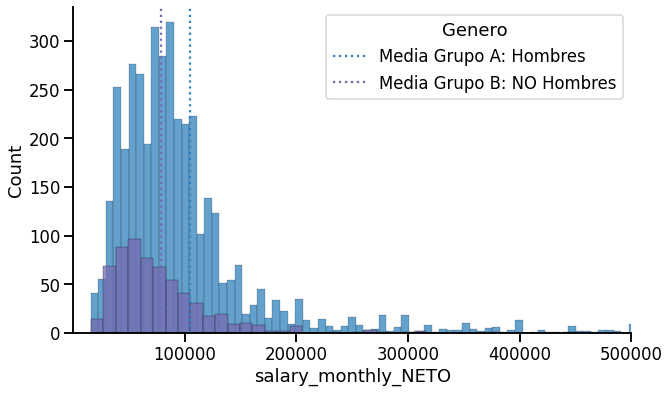

In [132]:
fig, ax = plt.subplots(figsize=(10,6))
seaborn.despine()
seaborn.histplot(groupA, x="salary_monthly_NETO", color= seaborn.color_palette("tab20c")[0] ,ax = ax,fill=True)
plt.axvline(groupA['salary_monthly_NETO'].mean(), color= seaborn.color_palette("tab20c")[0] ,linestyle='dotted')
seaborn.histplot(groupB, x="salary_monthly_NETO", color= seaborn.color_palette("tab20c")[12], ax = ax, fill=True)
plt.axvline(groupB['salary_monthly_NETO'].mean(), color= seaborn.color_palette("tab20c")[12] ,linestyle='dotted')
ax.set_xlim(1, 500000) # Se restringe la visualización al máximo de $500000.
plt.legend(labels=["Media Grupo A: Hombres","Media Grupo B: NO Hombres"], title = "Genero");


### Estimación puntual de la diferencia entre las medias poblacionales:

In [133]:
mean_diff = groupA["salary_monthly_NETO"].mean()-groupB["salary_monthly_NETO"].mean()
print(f"La estimación puntual del parametro diferencia de medias del salario neto mensual entre la población cuyo genero es Hombre")
print(f"y el resto de los generos(No Hombres) es de ${round(mean_diff,2)}")


La estimación puntual del parametro diferencia de medias del salario neto mensual entre la población cuyo genero es Hombre
y el resto de los generos(No Hombres) es de $25811.13


### Estimación por intervalo de confianza de la diferencia entre las medias poblacionales:


**Estadístico (Pivote)**
  
$\hspace{2cm} T=\frac{(\bar{X}-\bar{Y})-(μ_A- μ_B)}{S . \sqrt{\frac{n_1+n_2}{(n_1.n_2)}}} \hspace{2cm} S = \sqrt{\frac{\sum_{i=1}^{n_1}(X_i-\bar{X})^2+ \sum_{i=1}^{n_2}(Y_i-\bar{Y})^2}{n_1+n_2-2}} \\ \\ $

**Distribución del estadístico**

$ \hspace{2cm} T\sim t_{n_1+n_2-2}$

In [134]:
# NOTA: Se requiere instalar la version de scipy=1.6.0 o superior
# para poder aplicar en la función ttest_ind el parametro "alternative".
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

# SACAR
%pip install scipy==1.6.0

In [135]:
from scipy.stats import ttest_ind                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
from scipy.stats import t

# Probabilidad de error (Riesgo medible)
alpha = 0.05

# dof: Degrees of freedom
dof = nA + nB - 2

# Desvio standar de cada grupo
stdA = groupA['salary_monthly_NETO'].std()
stdB = groupB['salary_monthly_NETO'].std()
print(f"Dada la muestra bajo estudio, el desvío standar del grupo cuyo genero es Hombre es: {round(stdA,2)}")
print(f"y el desvio standar del grupo cuyo genero NO es Hombre es: {round(stdB,2)}")
    


Dada la muestra bajo estudio, el desvío standar del grupo cuyo genero es Hombre es: 102697.04
y el desvio standar del grupo cuyo genero NO es Hombre es: 54323.62


**Soporte de cálculo para el estadistico**

- Necesitamos calcular:

$\hspace{2cm}S = \sqrt{\frac{\sum_{i=1}^{n_1}(X_i-\bar{X})^2+ \sum_{i=1}^{n_2}(Y_i-\bar{Y})^2}{n_1+n_2-2}}$
 


 $\hspace{2cm}S^2 = \frac{\sum_{i=1}^{n_1}(X_i-\bar{X})^2+ \sum_{i=1}^{n_2}(Y_i-\bar{Y})^2}{n_1+n_2-2}$

$\hspace{2cm}$ **Partiendo de la definición de varianza y desvío standar**

$\hspace{2cm}Varianza_{muetra} = \frac{\sum_{i=1}^{n}(X_i-\bar{X})^2}{n-1}$

$\hspace{2cm}$**Desvío Standar**

$\hspace{2cm} \sigma_{muetra}= \sqrt{Varianza_{muetral}}= \sqrt{\frac{\sum_{i=1}^{n}(X_i-\bar{X})^2}{n-1}}$

$\hspace{2cm} \therefore$

$\hspace{2cm} \sum_{i=1}^{n}(X_i-\bar{X})^2 = (n-1)*\sigma ^{2}$

- Esta ultima expresión respalda el cálculo de la variable _**std_AB**_





$\hspace{2cm}S^2 = \frac{\sum_{i=1}^{n_1}(X_i-\bar{X})^2+ \sum_{i=1}^{n_2}(Y_i-\bar{Y})^2}{n_1+n_2-2}$






In [136]:
std_AB = numpy.sqrt(((nA - 1)*(stdA)**2 + (nB - 1)*(stdB)**2) / dof)

In [137]:
# Percent point function: ppf(q, df, loc=0, scale=1) 
# Calcula la función de distribución acumulada "inversa". Dada un distribución 
# de densidad de probabilidad (t, norm, etc ) determina el valor de la variable 
# que acumula una probabilidad específica.

# En otras palabras sea "q" una probabilidad dada, la función 
# devuelve x / P{T <= x} = q 
#   Donde: q es la probabilidad de obtener resultados <=x (distribución T).
# 
# Argumentos opcionales: 
#   loc (media) Por defecto 0
#   scale (desvío standar)(Por defecto 1).

t_val = t.ppf((1-alpha/2), dof)



In [138]:

# MoE: Margin of error
MoE = t_val * std_AB * numpy.sqrt(1/nA + 1/nB) 
li = mean_diff - MoE
ls = mean_diff + MoE
print(f'La diferencia entre las medias poblacionales de los grupos A y B es de {mean_diff:3.2f}') 
print(f'con el siguiente intervalo de confianza al {100-alpha*100}%: [{li:3.2f} - {ls:3.2f}]')

La diferencia entre las medias poblacionales de los grupos A y B es de 25811.13
con el siguiente intervalo de confianza al 95.0%: [17595.71 - 34026.55]


**Conclusión pendiente**

## Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos compenentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula**
##### Dada la población de programadores argentinos, la diferencia entre la media del _salario Neto_ para "_Hombres_" y la correspondiente media del salario Neto para _"otros géneros_" es cero.

$\\ \hspace{2cm}H_0:μ_A- μ_B=0\hspace{2cm}μ_A= μ_B \\ $

**Hipótesis Alternativa**

$\\ \hspace{2cm}H_1:μ_A- μ_B\neq 0\hspace{2cm}μ_A \neq μ_B \\ $

$\\ \hspace{2cm}H_1:μ_A- μ_B\neq 0\hspace{2cm}μ_A \neq μ_B \\ $


  **Definimos el nivel de significancia** $\alpha=0.05$

  **Estadístico (Pivote)**
  
$\hspace{2cm} T=\frac{(\bar{X}-\bar{Y})-(μ_A- μ_B)}{S\sqrt{\frac{n_1+n_2}{(n_1.n_2)}}} \hspace{2cm}S = \sqrt{\frac{\sum_{i=1}^{n_1}(X_i-\bar{X})^2+ \sum_{i=1}^{n_2}(Y_i-\bar{Y})^2}{n_1+n_2-2}} \\ \\ $

  **Distribución del estadístico**

$ \hspace{2cm} T\sim t_{n_1+n_2-2}$

**Supuestos:** Ambas poblaciones poseen distribuciones normales y comparten la misma varianza. Las muestras tomadas de cada población son aleatorias e independientes.


### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.
3. Los dos grupos de nuestra muestra tienen tamaños muy distintos. ¿Esto afecta al tests?

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

  2.2.1 Calculo del p-valor.


  Utilizamos la funcion ***_ttest_ind_*** del modulo scipy.stats. Descripción:

- Recibe como parametros de entradas las dos muestras a evaluar

- Devuelve el calculo del estadistico y el p-valor para el test planteado

- El parametro **equal_varbool**, (_True_ por defecto) aplica el test T de Student asumiendo que ambas varianzas poblacionales son iguales.
- Si por el contrario es configurado en _False_ aplica el **_Test de Welch_** (varianzas poblacionales distintas)

- El parametro opcional **alternative** {‘two-sided’, ‘less’, ‘greater’}, 
modela el "tipo de cola" a considerar para el test (psipy versión 1.6.0). 
En nuestro caso es dos colas dado que la hipotesis nula plantea una igualdad de medias. No hay relacion de orden que derive en uno u otro lado de la distribucion del estadistico. 

Configurando la función de acuerdo a lo expuesto previamente obtenemos:

In [139]:
# help(ttest_ind)
# ttest_ind(groupA.salary_monthly_NETO,groupB.salary_monthly_NETO, alternative='two-sided' , equal_var=True )
# Por defecto Colab tiene una versión que no soporta el parametro alternative y por defecto trabajan a dos colas.
ttest_ind(groupA.salary_monthly_NETO,groupB.salary_monthly_NETO, equal_var=True)


Ttest_indResult(statistic=6.15940871483383, pvalue=7.920790970055273e-10)

**Conclusiones y respuestas pendientes**

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

Resolución del ejercicio opcional

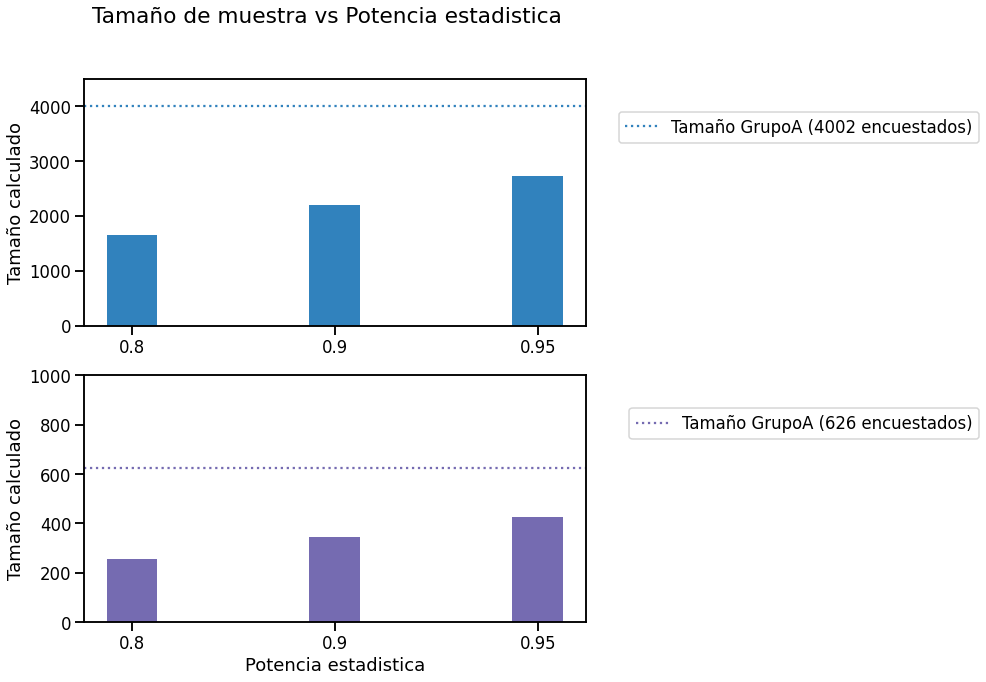

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power

#Lista con las potencia estadisticas a utilizar para calcular el tamaño de muestra asociado
power2evaluate=[0.8, 0.9, 0.95]

#Labels auxiliares
labels=["0.8", "0.9", "0.95"]

#Lista donde localizaremos los resultado
the_sizes=[]

#Parametros queridos por la funcion:
effect_size = (groupA.salary_monthly_NETO.mean() - groupB.salary_monthly_NETO.mean()) / groupB.salary_monthly_NETO.std()
alpha = 0.05
ratio = len(groupB) / len(groupA)

#Calculo de la cantidad de muestras segun la potencia estadistica propuesta.
#Los resultados se guardan en la lista "the_sizes"
for one_power_test in power2evaluate:
  the_sizes.append(int(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=one_power_test, ratio=ratio)))

#Conformacion de un dataframe con la inforacion de interes para su graficacion
d = {'label':labels,'power': power2evaluate, 'sizeB': the_sizes}
df= pd.DataFrame(d)
df["sizeA"]= df["sizeB"]/ratio
df= df.astype({"sizeA":int})

# Armado del grafico
fig, axs = plt.subplots(2,figsize=(9,10))
fig.suptitle("Tamaño de muestra vs Potencia estadistica")

axs[0].bar(df["label"],df["sizeA"], 0.25, label="Hombres", color= seaborn.color_palette("tab20c")[0])
plt.gcf().get_axes()[0].set_ylim(0,4500)
axs[0].set_ylabel("Tamaño calculado")

axs[0].axhline(y=4002, xmin=0, xmax=1, color= seaborn.color_palette("tab20c")[0], linestyle='dotted')
axs[0].legend(bbox_to_anchor=(1.0, 1.0, 0.8,-0.1), loc='upper right', labels=["Tamaño GrupoA (4002 encuestados)"])
plt.gcf().get_axes()[1].set_ylim(0,1000)
axs[1].bar(df["label"],df["sizeB"],0.25 , label="No Hombres", color= seaborn.color_palette("tab20c")[12])
axs[1].axhline(y=626, xmin=0, xmax=1, color= seaborn.color_palette("tab20c")[12], linestyle='dotted')
axs[1].set_ylabel("Tamaño calculado")
axs[1].legend(bbox_to_anchor=(1.0, 1.0, 0.8, -0.1), loc='upper right',labels=["Tamaño GrupoA (626 encuestados)"])
axs[1].set_xlabel("Potencia estadistica")

plt.show()



**Conclusiones y Respuestas**

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.
